**Image Captioning**

* The goal of image captioning is to convert a given input image into a natural language description.
* The image encoder is a convolutional neural network (CNN).
* The decoder is a long short-term memory (LSTM) network.
* The workflow might look like this:

![flow](https://i.ibb.co/qmrgfFv/encoder-decoder.png)

**1. Dataset**
* The Microsoft **C**ommon **O**bjects in **CO**ntext (MS COCO) dataset is one of the largest, publicly available image datasets for scene understanding. The dataset is commonly used to train and benchmark object detection, segmentation, and captioning algorithms.
* COCO does not overly pre-process images, instead these images come in a variety of shapes with a variety of objects and environment/lighting conditions that closely represent what you might get if you compiled images from many different cameras around the world.
* We can explore the dataset at [data website](https://cocodataset.org/#explore). When we actually train our model to generate captions, we will be using these images as input and _sampling_ one caption from a set of captions for each image to train on.
* We use the [coco api](https://github.com/cocodataset/cocoapi) to obtain the data.

**2. Training**
* For the encoder part, the pretrained CNN extracts the feature vector from a given input image. The feature vector is linearly transformed to have the same dimension as the input dimension of the LSTM network. 
* For the decoder part, source and target texts are predefined. For example, if the image description is "The man ready to swing at the pitch", the source sequence is a list containing \['<start>', 'Giraffes', 'standing', 'next', 'to', 'each', 'other'\] and the target sequence is a list containing \['The', 'man', 'ready', 'to', 'swing', 'at','the','pitch' '<end>'\]. Using these source and target sequences and the feature vector, the LSTM decoder is trained as a language model conditioned on the feature vector.

**3. Test Phase**
* In the test phase, the encoder part is almost same as the training phase. The only difference is that batchnorm layer uses moving average and variance instead of mini-batch statistics. This can be easily implemented using encoder.eval(). 
* For the decoder part, there is a significant difference between the training phase and the test phase. In the test phase, the LSTM decoder can't see the image description. To deal with this problem, the LSTM decoder feeds back the previosly generated word to the next input.

**4. How it works**

- Our model needs to take an image as input and output a text description of that image. The input image will be processed by CNN and will connect the output of the CNN to the input of the RNN which will allow us to generate descriptive texts.

![image](my_images/notebook/image-20210109224301856.png)

- We feed the image into a CNN. Here we can use a pre-trained network like VGG16 or Resnet.

![image](my_images/notebook/image-20210109224417127.png)

- At the end of these pre-trained networks we have a **softmax** classifier that outputs a vector of class scores.

![image](my_images/notebook/image-20210109224505494.png)

- We do not plan to classify the image in our case, instead we want a set of features that represents the spatial content in the image. To get that kind of spatial information. We will remove the final fully connected layer that classifies the image and look at earlier layer that distills the spatial information in the image.

![image](my_images/notebook/image-20210109224747985.png)

- Now we are using the CNN more like a feature extractor that compress huge amount of information contained in the original image into a smaller representation. That why it is called **encoder** cause it encodes the content of images into a smaller feature vector.

![image](my_images/notebook/image-20210109224940464.png)

- Then we can process this feature vector and use it as an initial input to the following RNN.
- We take the feature vector, and process then inject it into the RNN as input. The Feature Vector acts as the glue between CNN and RNN.
- It can sometimes prove useful to parse a CNN output through a additional fully-connected or linear layer before using it as an input to the RNN.

![image](my_images/notebook/image-20210109225258083.png)

- Recall the CNN we are using is pre-trained, then adding an untrained linear layer a the end of it allows us to tweak only the final layer as we train the entire model to generate captions.

![image](my_images/notebook/image-20210109225415398.png)

- After we extract the feature vector from the CNN and process it, we can then use this as the initial input into our RNN. The the RNN will decode processed feature vector and turn into a natural language. This is the decoder portion.

**Tokenize Captions**

- The RNN component of the captioning network is trained on the captions in the COCO dataset. We will train the RNN to predict the next word of the sentence based on the previous words. Do this we will need to transform the captions associated with the image into a list of tokenized words. This tokenization turns any strings into a list of integers.
- Here are the steps:
    1. Iterate through all of the training captions and create a dictionary that maps all unique words to a numerical index. Every word will have a corresponding integer value that we can find in this dictionary. These words are referred to as our vocabulary.
    2. The vocabulary typically also includes a few special tokens. Here we will add two special tokens to our dictionary to indicate the start and end of a sentence.
    3. The entire vocabulary is the length of the number of unique words in our training dataset plus two for the start and end tokens.
- Example: 

    ![image](my_images/notebook/image-20210109230738717.png)

    - The caption above is converted into a list of tokens with a special and token making the beginning and end of the sentence.
    - This list of tokens is then turned into a list of integers which come from our dictionary that maps each distinct word in the vocabulary to an integer value.
    - Before we can push this to the RNN as input, we need to add an Embedding Layer. The embedding layer transforms each word in a caption into a vector of desired consistent shape. After the embedding step, then we can start training the RNN.
    
**Encoder-Decoder model**
1. Encoder (CNN): For an image captioning system, we should use a trained architecture, such as ResNet or Inception, to extract features from the image. Like we did for the ensemble model, we can output a fixed vector length by using a linear layer and then make that linear layer trainable.
2. Decoder (LSTM): A decoder is a long short-term memory (LSTM) layer that will generate a caption for an image. To build a simple model, we can just pass the encoder embedding as input to the LSTM. However, this could be quite challenging for the decoder to learn; instead, it is common practice to provide the encoder embedding at every step of the decoder. Intuitively, a decoder learns to generate a sequence of text that best describes the caption of a given image.

## Training

In [20]:
import torch
import torch.nn as nn
from torchvision import transforms
from pycocotools.coco import COCO
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
import math

In [21]:
## Select appropriate values for the Python variables below.
batch_size = 10            # batch size
vocab_threshold = 4        # minimum word count threshold
vocab_from_file = True     # if True, load existing vocab file
embed_size = 256           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 3             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

# (Optional)  Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# Specify the learnable parameters of the model.
params = list(decoder.parameters())+list(encoder.embed.parameters())

# Define the optimizer.
optimizer = torch.optim.Adam(params,lr=0.001)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

annotations_file: opt/cocoapi/annotations/captions_train2014.json
Vocabulary successfully loaded from vocab.pkl file!
file: opt/cocoapi/annotations/captions_train2014.json
loading annotations into memory...
Done (t=1.01s)
creating index...
index created!
Obtaining caption lengths...


100%|████████████████████████████████████████████████████████████████████████| 414113/414113 [00:44<00:00, 9266.32it/s]


In [3]:
import torch.utils.data as data
import numpy as np
import os
import requests
import sys

# Open the training log file.
f = open(log_file, 'w')

for epoch in range(1, num_epochs+1):
    for i_step in range(1, total_step+1):
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

# Close the training log file.
f.close()

Epoch [1/3], Step [100/41412], Loss: 4.0346, Perplexity: 56.5230
Epoch [1/3], Step [200/41412], Loss: 4.0734, Perplexity: 58.75830
Epoch [1/3], Step [300/41412], Loss: 3.8873, Perplexity: 48.77779
Epoch [1/3], Step [400/41412], Loss: 3.7546, Perplexity: 42.7152
Epoch [1/3], Step [500/41412], Loss: 3.1733, Perplexity: 23.88657
Epoch [1/3], Step [600/41412], Loss: 3.0607, Perplexity: 21.34281
Epoch [1/3], Step [700/41412], Loss: 3.2529, Perplexity: 25.86530
Epoch [1/3], Step [800/41412], Loss: 3.1310, Perplexity: 22.8979
Epoch [1/3], Step [900/41412], Loss: 2.7570, Perplexity: 15.7522
Epoch [1/3], Step [1000/41412], Loss: 3.2385, Perplexity: 25.4949
Epoch [1/3], Step [1100/41412], Loss: 3.3643, Perplexity: 28.91261
Epoch [1/3], Step [1200/41412], Loss: 2.9393, Perplexity: 18.9019
Epoch [1/3], Step [1300/41412], Loss: 2.9504, Perplexity: 19.1133
Epoch [1/3], Step [1400/41412], Loss: 2.9968, Perplexity: 20.0209
Epoch [1/3], Step [1500/41412], Loss: 3.9766, Perplexity: 53.3328
Epoch [1/3], 

Epoch [1/3], Step [24600/41412], Loss: 2.3007, Perplexity: 9.98080
Epoch [1/3], Step [24700/41412], Loss: 2.2185, Perplexity: 9.19310
Epoch [1/3], Step [24800/41412], Loss: 2.3863, Perplexity: 10.8730
Epoch [1/3], Step [24900/41412], Loss: 2.7224, Perplexity: 15.2174
Epoch [1/3], Step [25000/41412], Loss: 2.3546, Perplexity: 10.5343
Epoch [1/3], Step [25100/41412], Loss: 2.1740, Perplexity: 8.79367
Epoch [1/3], Step [25200/41412], Loss: 3.0477, Perplexity: 21.0673
Epoch [1/3], Step [25300/41412], Loss: 1.8354, Perplexity: 6.26740
Epoch [1/3], Step [25400/41412], Loss: 2.3679, Perplexity: 10.6747
Epoch [1/3], Step [25500/41412], Loss: 2.0394, Perplexity: 7.686188
Epoch [1/3], Step [25600/41412], Loss: 2.1254, Perplexity: 8.37649
Epoch [1/3], Step [25700/41412], Loss: 3.0516, Perplexity: 21.1500
Epoch [1/3], Step [25800/41412], Loss: 1.9843, Perplexity: 7.27375
Epoch [1/3], Step [25900/41412], Loss: 2.0768, Perplexity: 7.97854
Epoch [1/3], Step [26000/41412], Loss: 2.1137, Perplexity: 8.

Epoch [2/3], Step [7700/41412], Loss: 2.9272, Perplexity: 18.6746
Epoch [2/3], Step [7800/41412], Loss: 2.1009, Perplexity: 8.173338
Epoch [2/3], Step [7900/41412], Loss: 2.1764, Perplexity: 8.81437
Epoch [2/3], Step [8000/41412], Loss: 3.0148, Perplexity: 20.3846
Epoch [2/3], Step [8100/41412], Loss: 3.0258, Perplexity: 20.6102
Epoch [2/3], Step [8200/41412], Loss: 2.2548, Perplexity: 9.53387
Epoch [2/3], Step [8300/41412], Loss: 2.3911, Perplexity: 10.9255
Epoch [2/3], Step [8400/41412], Loss: 2.1376, Perplexity: 8.47872
Epoch [2/3], Step [8500/41412], Loss: 2.4679, Perplexity: 11.7978
Epoch [2/3], Step [8600/41412], Loss: 2.2751, Perplexity: 9.72883
Epoch [2/3], Step [8700/41412], Loss: 2.8924, Perplexity: 18.0374
Epoch [2/3], Step [8800/41412], Loss: 2.5932, Perplexity: 13.3724
Epoch [2/3], Step [8900/41412], Loss: 1.8227, Perplexity: 6.18850
Epoch [2/3], Step [9000/41412], Loss: 2.0862, Perplexity: 8.05430
Epoch [2/3], Step [9100/41412], Loss: 2.0407, Perplexity: 7.69588
Epoch [2/

Epoch [2/3], Step [32100/41412], Loss: 2.2287, Perplexity: 9.28775
Epoch [2/3], Step [32200/41412], Loss: 2.2900, Perplexity: 9.87488
Epoch [2/3], Step [32300/41412], Loss: 2.6687, Perplexity: 14.4217
Epoch [2/3], Step [32400/41412], Loss: 2.4356, Perplexity: 11.4228
Epoch [2/3], Step [32500/41412], Loss: 2.6807, Perplexity: 14.5953
Epoch [2/3], Step [32600/41412], Loss: 2.1670, Perplexity: 8.73217
Epoch [2/3], Step [32700/41412], Loss: 2.2556, Perplexity: 9.54104
Epoch [2/3], Step [32800/41412], Loss: 1.9470, Perplexity: 7.00780
Epoch [2/3], Step [32900/41412], Loss: 2.4697, Perplexity: 11.8192
Epoch [2/3], Step [33000/41412], Loss: 1.9637, Perplexity: 7.12582
Epoch [2/3], Step [33100/41412], Loss: 2.3318, Perplexity: 10.2960
Epoch [2/3], Step [33200/41412], Loss: 2.8687, Perplexity: 17.6135
Epoch [2/3], Step [33300/41412], Loss: 2.3593, Perplexity: 10.5837
Epoch [2/3], Step [33400/41412], Loss: 1.9213, Perplexity: 6.82968
Epoch [2/3], Step [33500/41412], Loss: 2.1836, Perplexity: 8.8

Epoch [3/3], Step [15200/41412], Loss: 2.1989, Perplexity: 9.01472
Epoch [3/3], Step [15300/41412], Loss: 1.6976, Perplexity: 5.46071
Epoch [3/3], Step [15400/41412], Loss: 1.8057, Perplexity: 6.08423
Epoch [3/3], Step [15500/41412], Loss: 1.8868, Perplexity: 6.59791
Epoch [3/3], Step [15600/41412], Loss: 2.3685, Perplexity: 10.6817
Epoch [3/3], Step [15700/41412], Loss: 2.3946, Perplexity: 10.9636
Epoch [3/3], Step [15800/41412], Loss: 2.2791, Perplexity: 9.76836
Epoch [3/3], Step [15900/41412], Loss: 2.3839, Perplexity: 10.84705
Epoch [3/3], Step [16000/41412], Loss: 2.3447, Perplexity: 10.4299
Epoch [3/3], Step [16100/41412], Loss: 2.5538, Perplexity: 12.8555
Epoch [3/3], Step [16200/41412], Loss: 2.6497, Perplexity: 14.1504
Epoch [3/3], Step [16300/41412], Loss: 2.0593, Perplexity: 7.84028
Epoch [3/3], Step [16400/41412], Loss: 2.6316, Perplexity: 13.8967
Epoch [3/3], Step [16500/41412], Loss: 2.2173, Perplexity: 9.18236
Epoch [3/3], Step [16600/41412], Loss: 2.3040, Perplexity: 10

Epoch [3/3], Step [39600/41412], Loss: 1.9810, Perplexity: 7.24979
Epoch [3/3], Step [39700/41412], Loss: 2.0203, Perplexity: 7.54068
Epoch [3/3], Step [39800/41412], Loss: 2.3011, Perplexity: 9.98535
Epoch [3/3], Step [39900/41412], Loss: 2.0024, Perplexity: 7.406521
Epoch [3/3], Step [40000/41412], Loss: 1.9954, Perplexity: 7.35514
Epoch [3/3], Step [40100/41412], Loss: 2.5131, Perplexity: 12.3431
Epoch [3/3], Step [40200/41412], Loss: 2.0259, Perplexity: 7.58291
Epoch [3/3], Step [40300/41412], Loss: 2.4777, Perplexity: 11.9134
Epoch [3/3], Step [40400/41412], Loss: 2.0976, Perplexity: 8.14637
Epoch [3/3], Step [40500/41412], Loss: 1.9203, Perplexity: 6.82290
Epoch [3/3], Step [40600/41412], Loss: 2.0940, Perplexity: 8.11758
Epoch [3/3], Step [40700/41412], Loss: 2.1531, Perplexity: 8.61135
Epoch [3/3], Step [40800/41412], Loss: 2.3860, Perplexity: 10.8697
Epoch [3/3], Step [40900/41412], Loss: 1.9212, Perplexity: 6.82934
Epoch [3/3], Step [41000/41412], Loss: 2.2216, Perplexity: 9.

## Prediction

In [24]:
from data_loader import get_loader
from torchvision import transforms
import torch

In [25]:
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])


data_loader = get_loader(transform=transform_test, mode='test')

annotations_file: opt/cocoapi/annotations/image_info_test2014.json
Vocabulary successfully loaded from vocab.pkl file!


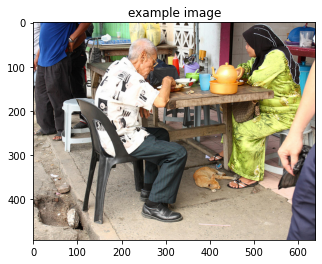

In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [28]:
# Watch for any changes in model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# Specify the saved models to load.
encoder_file = 'encoder-3.pkl' 
decoder_file = 'decoder-3.pkl'

# Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DecoderRNN(
  (word_embedding): Embedding(9955, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=9955, bias=True)
)

In [29]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 80, 13, 51, 224, 192, 3, 112, 18]


In [30]:
def clean_sentence(output):
    cleaned_list = []
    for index in output:
        if  (index == 1) :
            continue
        cleaned_list.append(data_loader.dataset.vocab.idx2word[index])
    cleaned_list = cleaned_list[1:-1] # Discard <start> and <end> 

    sentence = ' '.join(cleaned_list) # Convert list of string to                                                    
    sentence = sentence.capitalize()    
    return sentence

In [31]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: A group of people sitting around a table


In [32]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

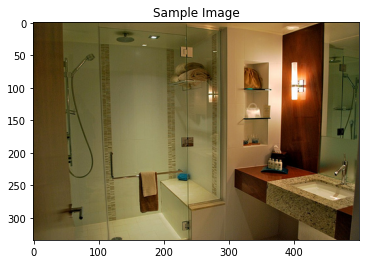

A bathroom with a sink , toilet , and a mirror


In [59]:
get_prediction()

### More Test

In [60]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

def get_custom_image_prediction(image_path, encoder, decoder, device):
    # Load and preprocess the image
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    orig_image = Image.open(image_path).convert('RGB')
    image = transform(orig_image).unsqueeze(0).to(device)

    # Obtain features from the image using the encoder
    features = encoder(image).unsqueeze(1)

    # Generate a caption for the image using the decoder
    output = decoder.sample(features)
    sentence = clean_sentence(output)
    
    # Display the original image
    plt.imshow(orig_image)
    plt.title('Sample Image')
    plt.axis('off')
    plt.show()

    # Print the generated caption
    print(sentence)

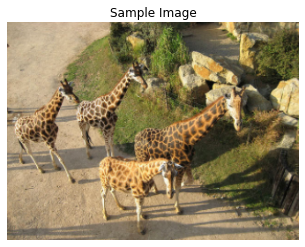

A giraffe standing in a field with trees in the background


In [61]:
image_path = 'my_images/example.png'
get_custom_image_prediction(image_path, encoder, decoder, device)